# Layer & Demographic Comparison Analysis

This notebook provides comprehensive visualizations comparing results across:
- **3 EXAONE layers**: Q1 (25%), Q2 (50%), Q3 (75%)
- **9 demographic dimensions**: 성별, 인종, 종교, 나이, 직업, 학력, 지역, 정치성향, 성적지향

## Visualizations:

1. **Probe Accuracy Comparison**: Linear probe accuracy by layer and demographic
2. **IG² Score Comparison**: Top IG² scores by layer and demographic
3. **Training Loss Comparison**: SAE and probe training curves

## Prerequisites:
- Run pipeline for all 9 demographics and all 3 layers
- Results stored in `results/{stage}/{demographic}/`

In [1]:
import os
import sys
import warnings
import pickle
from pathlib import Path
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.visualization import ensure_korean_font
from src.utils import load_json

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


In [2]:
# Setup Korean font
font_name = ensure_korean_font()

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Font configured: ['DejaVu Sans']


In [ ]:
# Configuration
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage
STAGE = "full"

# SAE type
SAE_TYPE = "gated"

# Layer quantiles to compare
LAYER_QUANTILES = ["q1", "q2", "q3"]
LAYER_LABELS = {
    "q1": "Layer 8",
    "q2": "Layer 16",
    "q3": "Layer 24"
}

# Load demographics
demo_dict = load_json(DATA_DIR / "demographic_dict_ko.json")
DEMOGRAPHICS = list(demo_dict.keys())
DEMOGRAPHIC_EN = {d: demo_dict[d]['dimension_en'] for d in DEMOGRAPHICS}

print(f"Stage: {STAGE}")
print(f"SAE Type: {SAE_TYPE}")
print(f"Layer Quantiles: {LAYER_QUANTILES}")
print(f"\nDemographics ({len(DEMOGRAPHICS)}):")
for d in DEMOGRAPHICS:
    print(f"  - {d} ({DEMOGRAPHIC_EN[d]})")

---
## Data Loading Functions

In [4]:
def load_probe_results(results_dir, stage, demographic, layer_quantile):
    """
    Load linear probe training results.
    
    Returns:
        dict with 'accuracy', 'best_accuracy', 'losses', etc.
        or None if not found
    """
    # Use layer-specific filename (new format)
    probe_path = results_dir / stage / demographic / 'probe' / f'{layer_quantile}_linear_probe.pt'
    metrics_path = results_dir / stage / demographic / 'probe' / f'{layer_quantile}_training_metrics.pkl'
    
    # Fallback to legacy non-layer-specific path
    if not probe_path.exists():
        probe_path = results_dir / stage / demographic / 'probe' / 'linear_probe.pt'
        metrics_path = results_dir / stage / demographic / 'probe' / 'training_metrics.pkl'
    
    if not probe_path.exists():
        return None
    
    result = {}
    
    # Load probe checkpoint
    checkpoint = torch.load(probe_path, map_location='cpu')
    result['final_accuracy'] = checkpoint.get('final_accuracy', 0)
    result['best_accuracy'] = checkpoint.get('best_accuracy', 0)
    result['layer_quantile'] = checkpoint.get('layer_quantile', layer_quantile)
    
    # Load training metrics if available
    if metrics_path.exists():
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
        result['losses'] = metrics.get('losses', [])
        result['accuracies'] = metrics.get('accuracies', [])
    
    return result


def load_ig2_results(results_dir, stage, demographic, layer_quantile):
    """
    Load IG² attribution results.
    
    Returns:
        dict with 'feature_scores', 'top_features', etc.
        or None if not found
    """
    # Use layer-specific filename (new format)
    ig2_path = results_dir / stage / demographic / 'ig2' / f'{layer_quantile}_ig2_results.pt'
    
    # Fallback to legacy non-layer-specific path
    if not ig2_path.exists():
        legacy_path = results_dir / stage / demographic / 'ig2' / 'ig2_results.pt'
        if legacy_path.exists():
            print(f"Warning: Using legacy IG2 file (no layer prefix): {legacy_path}")
            ig2_path = legacy_path
    
    if not ig2_path.exists():
        raise FileNotFoundError(f"IG² results not found: {ig2_path}")
    
    data = torch.load(ig2_path, map_location='cpu')
    return data


def load_sae_training_logs(results_dir, stage, sae_type, layer_quantile):
    """
    Load SAE training logs.
    
    Returns:
        pandas DataFrame with training logs
        or None if not found
    """
    log_path = results_dir / "models" / f"sae-{sae_type}_{stage}_{layer_quantile}" / "training_logs.csv"
    
    if not log_path.exists():
        return None
    
    return pd.read_csv(log_path)


print("Data loading functions defined.")

Data loading functions defined.


In [5]:
# Scan for available results
available_results = defaultdict(lambda: defaultdict(dict))

print("Scanning for available results...\n")

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        # Check probe results
        probe_results = load_probe_results(RESULTS_DIR, STAGE, demo, lq)
        if probe_results:
            available_results[demo][lq]['probe'] = probe_results
        
        # Check IG2 results
        ig2_results = load_ig2_results(RESULTS_DIR, STAGE, demo, lq)
        if ig2_results:
            available_results[demo][lq]['ig2'] = ig2_results

# Check SAE training logs (SAE is shared across demographics)
sae_logs = {}
for lq in LAYER_QUANTILES:
    logs = load_sae_training_logs(RESULTS_DIR, STAGE, SAE_TYPE, lq)
    if logs is not None:
        sae_logs[lq] = logs

# Summary
print("Available Results Summary:")
print("=" * 70)
print(f"{'Demographic':<15} | {'Q1 (25%)':<15} | {'Q2 (50%)':<15} | {'Q3 (75%)':<15}")
print("-" * 70)

for demo in DEMOGRAPHICS:
    row = f"{demo:<15} |"
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            has_probe = 'probe' in available_results[demo][lq]
            has_ig2 = 'ig2' in available_results[demo][lq]
            status = f"P:{'+' if has_probe else '-'} I:{'+' if has_ig2 else '-'}"
        else:
            status = "--"
        row += f" {status:<14}|"
    print(row)

print("-" * 70)
print(f"\nSAE Training Logs: {', '.join(sae_logs.keys()) if sae_logs else 'None'}")

Scanning for available results...

Available Results Summary:
Demographic     | Q1 (25%)        | Q2 (50%)        | Q3 (75%)       
----------------------------------------------------------------------
성별              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
인종              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
종교              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
성적지향            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
나이              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
외모              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
경제수준            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
정치성향            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
직업              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
----------------------------------------------------------------------

SAE Training Logs: q1, q2, q3


---
## 1. Probe Accuracy Comparison

### How It's Computed:
The linear probe is trained on SAE features to predict which demographic group generated each text. Accuracy = (correct predictions) / (total samples), measured on the validation set after training converges. Higher accuracy indicates SAE features successfully encode demographic-relevant information.

### Analysis:
High accuracy (near 100%) across all demographics and layers confirms that demographic bias is consistently encoded in the model's representations. Similar accuracy across layers suggests bias information persists throughout the model depth. Any demographic with lower accuracy may have more subtle or distributed bias encoding.

In [6]:
# Collect accuracy data
accuracy_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                probe = available_results[demo][lq]['probe']
                accuracy_data.append({
                    'Demographic': demo,
                    'Demographic_EN': DEMOGRAPHIC_EN[demo],
                    'Layer': LAYER_LABELS[lq],
                    'Layer_Quantile': lq,
                    'Final_Accuracy': probe['final_accuracy'],
                    'Best_Accuracy': probe['best_accuracy']
                })

df_accuracy = pd.DataFrame(accuracy_data)

if len(df_accuracy) > 0:
    print(f"Collected accuracy data for {len(df_accuracy)} experiments")
    print(df_accuracy.head(10))
else:
    print("No accuracy data found. Please run the training pipeline first.")

Collected accuracy data for 27 experiments
  Demographic Demographic_EN           Layer Layer_Quantile  Final_Accuracy  \
0          성별         gender  Layer Q1 (25%)             q1             1.0   
1          성별         gender  Layer Q2 (50%)             q2             1.0   
2          성별         gender  Layer Q3 (75%)             q3             1.0   
3          인종      ethnicity  Layer Q1 (25%)             q1             1.0   
4          인종      ethnicity  Layer Q2 (50%)             q2             1.0   
5          인종      ethnicity  Layer Q3 (75%)             q3             1.0   
6          종교       religion  Layer Q1 (25%)             q1             1.0   
7          종교       religion  Layer Q2 (50%)             q2             1.0   
8          종교       religion  Layer Q3 (75%)             q3             1.0   
9        성적지향      sexuality  Layer Q1 (25%)             q1             1.0   

   Best_Accuracy  
0            1.0  
1            1.0  
2            1.0  
3          

In [ ]:
if len(df_accuracy) > 0:
    # Create heatmap of accuracy by demographic and layer
    # Use English labels for the y-axis, preserve original demographic order
    
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    pivot_acc = df_accuracy.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Best_Accuracy')
    pivot_acc = pivot_acc.reindex(demo_en_ordered)  # Reorder rows to match DEMOGRAPHICS order
    
    # Reorder columns
    pivot_acc = pivot_acc[['q1', 'q2', 'q3']]
    pivot_acc.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        pivot_acc,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0.0,
        vmax=1.0,
        ax=ax,
        cbar_kws={'label': 'Accuracy'},
        linewidths=0.5
    )
    
    ax.set_title('Linear Probe Accuracy (gSAE + Linear Probe)\nby Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_accuracy_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nAccuracy Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_accuracy[df_accuracy['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean Accuracy:   {lq_data['Best_Accuracy'].mean():.3f}")
            print(f"  Std Accuracy:    {lq_data['Best_Accuracy'].std():.3f}")
            print(f"  Min Accuracy:    {lq_data['Best_Accuracy'].min():.3f}")
            print(f"  Max Accuracy:    {lq_data['Best_Accuracy'].max():.3f}")

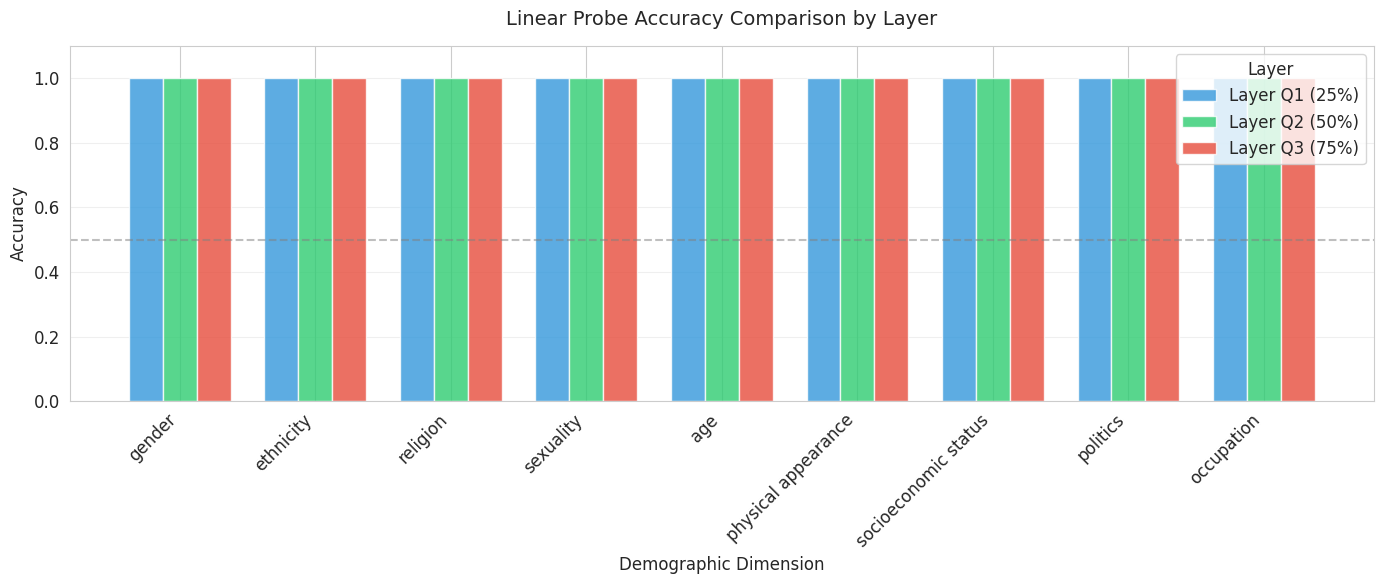

In [8]:
if len(df_accuracy) > 0:
    # Grouped bar chart with English labels
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Get English labels in order
    demographics_en = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    x = np.arange(len(DEMOGRAPHICS))
    width = 0.25
    
    colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red
    
    for i, lq in enumerate(LAYER_QUANTILES):
        lq_data = df_accuracy[df_accuracy['Layer_Quantile'] == lq]
        
        # Get accuracy for each demographic (in order)
        accuracies = []
        for demo in DEMOGRAPHICS:
            demo_data = lq_data[lq_data['Demographic'] == demo]
            if len(demo_data) > 0:
                accuracies.append(demo_data['Best_Accuracy'].values[0])
            else:
                accuracies.append(0)
        
        ax.bar(x + i * width, accuracies, width, label=LAYER_LABELS[lq], color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Demographic Dimension', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Linear Probe Accuracy Comparison by Layer', fontsize=14, pad=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels(demographics_en, rotation=45, ha='right')  # Use English labels
    ax.legend(title='Layer', loc='upper right')
    ax.set_ylim(0, 1.1)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_accuracy_bars_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 2. IG² Score Comparison

### How It's Computed:
IG² (Integrated Gradients Squared) measures each SAE feature's contribution to bias prediction by computing gradients along the path from zero to the actual feature value, then squaring and averaging. Higher IG² score means the feature is more important for the probe's demographic classification. Features above a threshold are labeled as "bias features."

### Analysis:
The heatmap shows the maximum IG² score (most important bias feature) for each demographic-layer combination. Higher scores indicate more concentrated bias encoding (fewer features carry most of the signal). Variation across layers reveals where in the model bias is most strongly encoded - typically middle layers (Q2) show balanced importance.

In [9]:
# Collect IG² statistics
ig2_stats = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'ig2' in available_results[demo][lq]:
                ig2_data = available_results[demo][lq]['ig2']
                
                # Get feature scores
                if isinstance(ig2_data, dict):
                    scores = ig2_data.get('feature_scores', ig2_data.get('ig2_scores', None))
                else:
                    scores = ig2_data
                
                if scores is not None:
                    if isinstance(scores, torch.Tensor):
                        scores_np = scores.cpu().numpy()
                    else:
                        scores_np = scores
                    
                    # Compute statistics
                    top_10 = np.sort(scores_np)[-10:]
                    top_50 = np.sort(scores_np)[-50:]
                    top_100 = np.sort(scores_np)[-100:]
                    
                    # Get the index of the max score (top neuron)
                    max_neuron_idx = int(np.argmax(scores_np))
                    
                    ig2_stats.append({
                        'Demographic': demo,
                        'Demographic_EN': DEMOGRAPHIC_EN[demo],
                        'Layer': LAYER_LABELS[lq],
                        'Layer_Quantile': lq,
                        'Max_Score': scores_np.max(),
                        'Max_Neuron_Idx': max_neuron_idx,
                        'Top10_Mean': top_10.mean(),
                        'Top50_Mean': top_50.mean(),
                        'Top100_Mean': top_100.mean(),
                        'Total_Nonzero': (scores_np > 0).sum(),
                        'Scores': scores_np  # Keep for detailed analysis
                    })

df_ig2 = pd.DataFrame(ig2_stats)

if len(df_ig2) > 0:
    print(f"Collected IG² data for {len(df_ig2)} experiments")
    print(df_ig2[['Demographic', 'Demographic_EN', 'Layer_Quantile', 'Max_Score', 'Max_Neuron_Idx', 'Top10_Mean', 'Total_Nonzero']].head(10))
else:
    print("No IG² data found. Please run the IG² computation pipeline first.")

Collected IG² data for 27 experiments
  Demographic Demographic_EN Layer_Quantile  Max_Score  Max_Neuron_Idx  \
0          성별         gender             q1   0.387639           53911   
1          성별         gender             q2   0.437685           67974   
2          성별         gender             q3   0.448949           71521   
3          인종      ethnicity             q1   0.687645           12574   
4          인종      ethnicity             q2   0.497052           83760   
5          인종      ethnicity             q3   0.493965           70570   
6          종교       religion             q1   0.622936           38258   
7          종교       religion             q2   0.543364           67974   
8          종교       religion             q3   0.526453           70570   
9        성적지향      sexuality             q1   0.573826           38258   

   Top10_Mean  Total_Nonzero  
0    0.301691            192  
1    0.301581            635  
2    0.321749           2294  
3    0.399523          

In [ ]:
if len(df_ig2) > 0:
    # Heatmap of max IG² scores with neuron indices
    # Use English labels for the y-axis, preserve original demographic order
    
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    # Pivot and reindex to maintain original order
    pivot_ig2 = df_ig2.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Max_Score')
    pivot_ig2 = pivot_ig2.reindex(demo_en_ordered)  # Reorder rows to match DEMOGRAPHICS order
    pivot_ig2 = pivot_ig2[['q1', 'q2', 'q3']]
    pivot_ig2.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    # Also get neuron indices for annotations
    pivot_neuron = df_ig2.pivot(index='Demographic_EN', columns='Layer_Quantile', values='Max_Neuron_Idx')
    pivot_neuron = pivot_neuron.reindex(demo_en_ordered)  # Same reordering
    pivot_neuron = pivot_neuron[['q1', 'q2', 'q3']]
    pivot_neuron.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    # Create custom annotations with score and neuron index
    annot_labels = []
    for idx in pivot_ig2.index:
        row_labels = []
        for col in pivot_ig2.columns:
            score = pivot_ig2.loc[idx, col]
            neuron_idx = int(pivot_neuron.loc[idx, col])
            row_labels.append(f'{score:.4f}\n(#{neuron_idx})')
        annot_labels.append(row_labels)
    annot_array = np.array(annot_labels)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    sns.heatmap(
        pivot_ig2,
        annot=annot_array,
        fmt='',
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'Max IG² Score'},
        linewidths=0.5,
        annot_kws={'fontsize': 10}
    )
    
    ax.set_title('Max IG² Score with Neuron Index (SAE Neuron Importance)\nby Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_max_scores_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top neuron indices per demographic (in same order as heatmap)
    print("\nTop Neuron Indices (Max IG² Score) per Demographic:")
    print("=" * 70)
    for demo_en in demo_en_ordered:
        demo_data = df_ig2[df_ig2['Demographic_EN'] == demo_en]
        if len(demo_data) > 0:
            # Get Q2 (middle layer) as representative
            q2_data = demo_data[demo_data['Layer_Quantile'] == 'q2']
            if len(q2_data) > 0:
                neuron_idx = q2_data['Max_Neuron_Idx'].values[0]
                score = q2_data['Max_Score'].values[0]
                print(f"  {demo_en:25s}: Neuron #{neuron_idx:5d} (IG²={score:.4f})")

In [ ]:
if len(df_ig2) > 0:
    # Top-K mean IG² scores comparison with English labels
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Create ordered list of English labels matching DEMOGRAPHICS order
    demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    
    metrics = ['Top10_Mean', 'Top50_Mean', 'Top100_Mean']
    titles = ['Top-10 Mean IG² Score', 'Top-50 Mean IG² Score', 'Top-100 Mean IG² Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        
        # Use English demographic labels, preserve original order
        pivot = df_ig2.pivot(index='Demographic_EN', columns='Layer_Quantile', values=metric)
        pivot = pivot.reindex(demo_en_ordered)  # Reorder rows to match DEMOGRAPHICS order
        pivot = pivot[['q1', 'q2', 'q3']]
        pivot.columns = ['Layer 8', 'Layer 16', 'Layer 24']
        
        pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
        ax.set_title(f'{title}', fontsize=12, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('IG² Score', fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Layer', loc='upper right')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('IG² Score Comparison (SAE Neuron Importance) Across Layers', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_topk_comparison_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

### IG² Score Distribution

This histogram shows the distribution of all non-zero IG² scores across demographics for each layer. A long-tailed distribution with few high-scoring features indicates concentrated bias encoding (good for targeted intervention). More uniform distributions suggest diffuse bias encoding across many features.

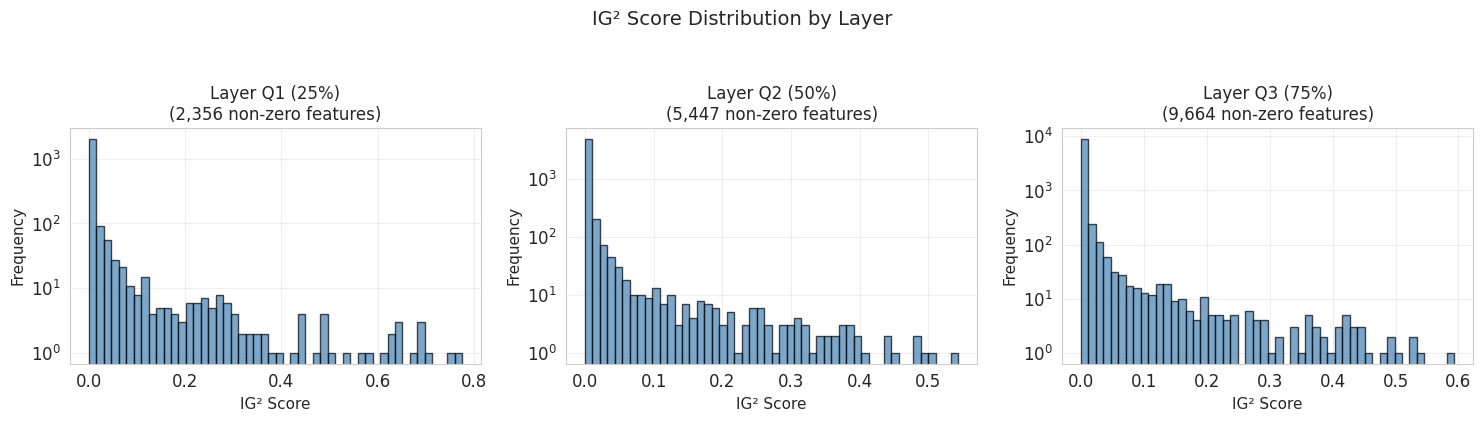

In [12]:
if len(df_ig2) > 0:
    # Distribution of IG² scores for each layer (aggregated across demographics)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, lq in enumerate(LAYER_QUANTILES):
        ax = axes[idx]
        
        lq_data = df_ig2[df_ig2['Layer_Quantile'] == lq]
        
        if len(lq_data) > 0:
            # Concatenate all scores for this layer
            all_scores = np.concatenate([row['Scores'] for _, row in lq_data.iterrows()])
            
            # Plot histogram (only positive scores)
            positive_scores = all_scores[all_scores > 0]
            ax.hist(positive_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_xlabel('IG² Score', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{LAYER_LABELS[lq]}\n({len(positive_scores):,} non-zero features)', fontsize=12)
            ax.set_yscale('log')
            ax.grid(alpha=0.3)
    
    plt.suptitle('IG² Score Distribution by Layer', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_distribution_by_layer_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 3. Training Loss Comparison

### How It's Computed:
SAE training minimizes reconstruction loss (MSE between input and reconstructed activations) plus sparsity loss (encouraging few active features). L0 sparsity counts the average number of active features per input. Linear probe training minimizes cross-entropy loss for demographic classification.

### Analysis:
Lower final reconstruction loss indicates better representation quality. Sparsity L0 around 50-200 features (out of 100K) suggests good feature selectivity. Converging probe loss confirms successful demographic encoding extraction. Similar training dynamics across layers indicates consistent optimization behavior.

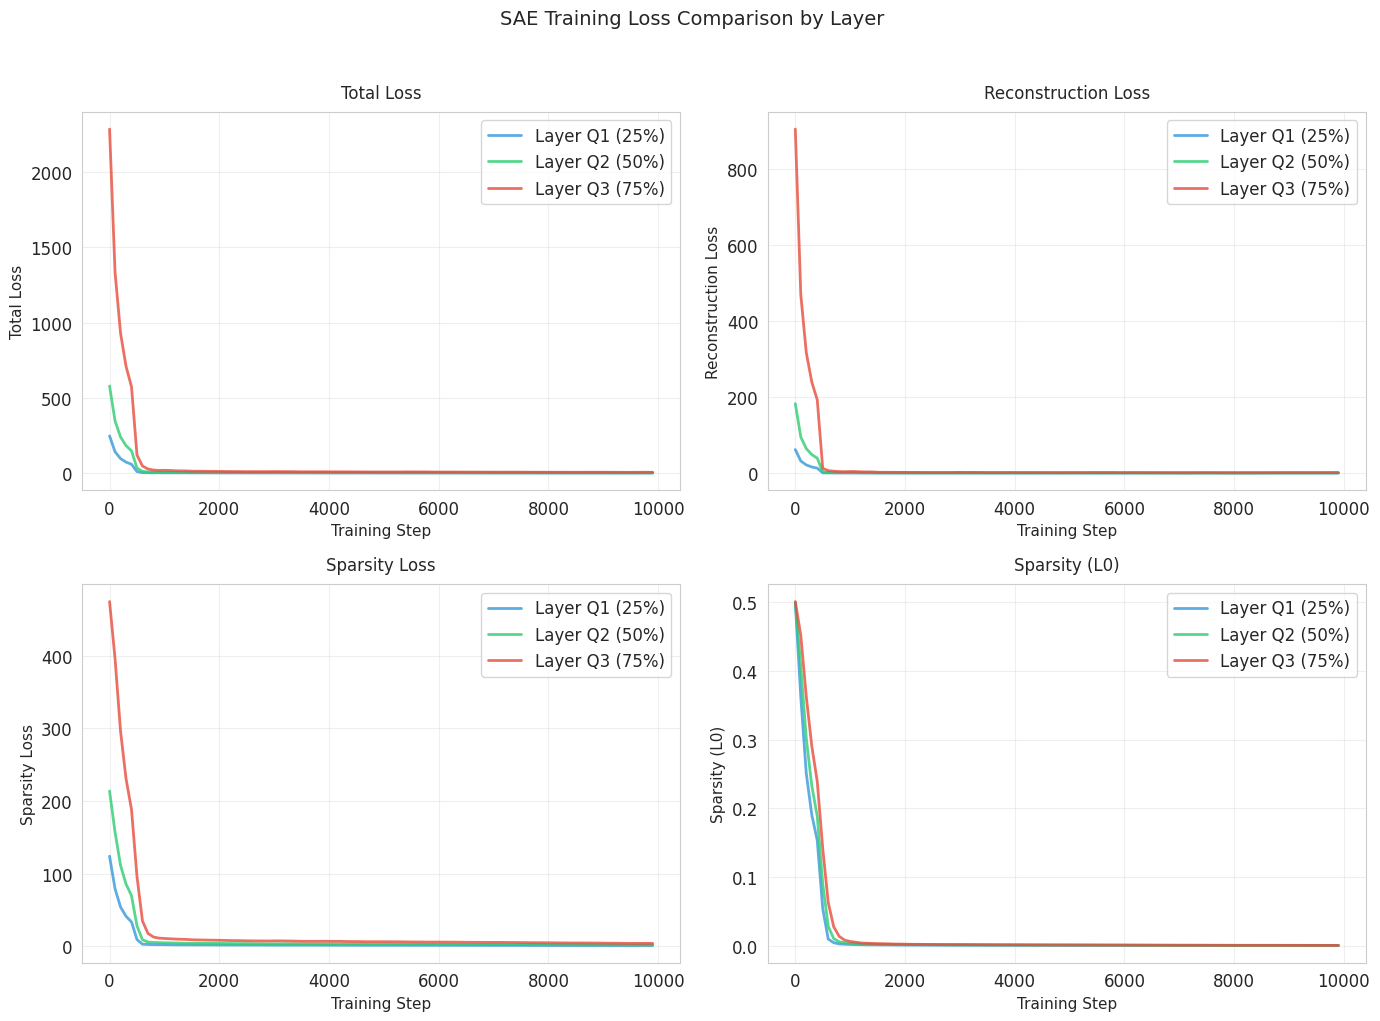


SAE Final Training Statistics:

Layer Q1 (25%):
  Total Steps: 100
  Final Total Loss: 0.9151
  Final Recon Loss: 0.0462
  Final Sparsity L0: 0.0002

Layer Q2 (50%):
  Total Steps: 100
  Final Total Loss: 2.0123
  Final Recon Loss: 0.1948
  Final Sparsity L0: 0.0003

Layer Q3 (75%):
  Total Steps: 100
  Final Total Loss: 5.5769
  Final Recon Loss: 0.9240
  Final Sparsity L0: 0.0004


In [13]:
# SAE Training Loss Comparison
if sae_logs:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    metrics = ['total_loss', 'recon_loss', 'sparsity_loss', 'sparsity_l0']
    titles = ['Total Loss', 'Reconstruction Loss', 'Sparsity Loss', 'Sparsity (L0)']
    
    colors = {'q1': '#3498db', 'q2': '#2ecc71', 'q3': '#e74c3c'}
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        
        for lq in LAYER_QUANTILES:
            if lq in sae_logs and metric in sae_logs[lq].columns:
                logs = sae_logs[lq]
                # Smooth the curve
                window = max(1, len(logs) // 20)
                smoothed = logs[metric].rolling(window=window, min_periods=1).mean()
                ax.plot(logs['step'], smoothed, label=LAYER_LABELS[lq], 
                       color=colors[lq], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Training Step', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.set_title(f'{title}', fontsize=12, pad=10)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
    
    plt.suptitle('SAE Training Loss Comparison by Layer', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"sae_training_loss_comparison_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Final statistics
    print("\nSAE Final Training Statistics:")
    print("=" * 70)
    for lq in LAYER_QUANTILES:
        if lq in sae_logs:
            logs = sae_logs[lq]
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Total Steps: {len(logs)}")
            print(f"  Final Total Loss: {logs['total_loss'].iloc[-1]:.4f}")
            print(f"  Final Recon Loss: {logs['recon_loss'].iloc[-1]:.4f}")
            print(f"  Final Sparsity L0: {logs['sparsity_l0'].iloc[-1]:.4f}")
else:
    print("No SAE training logs found.")

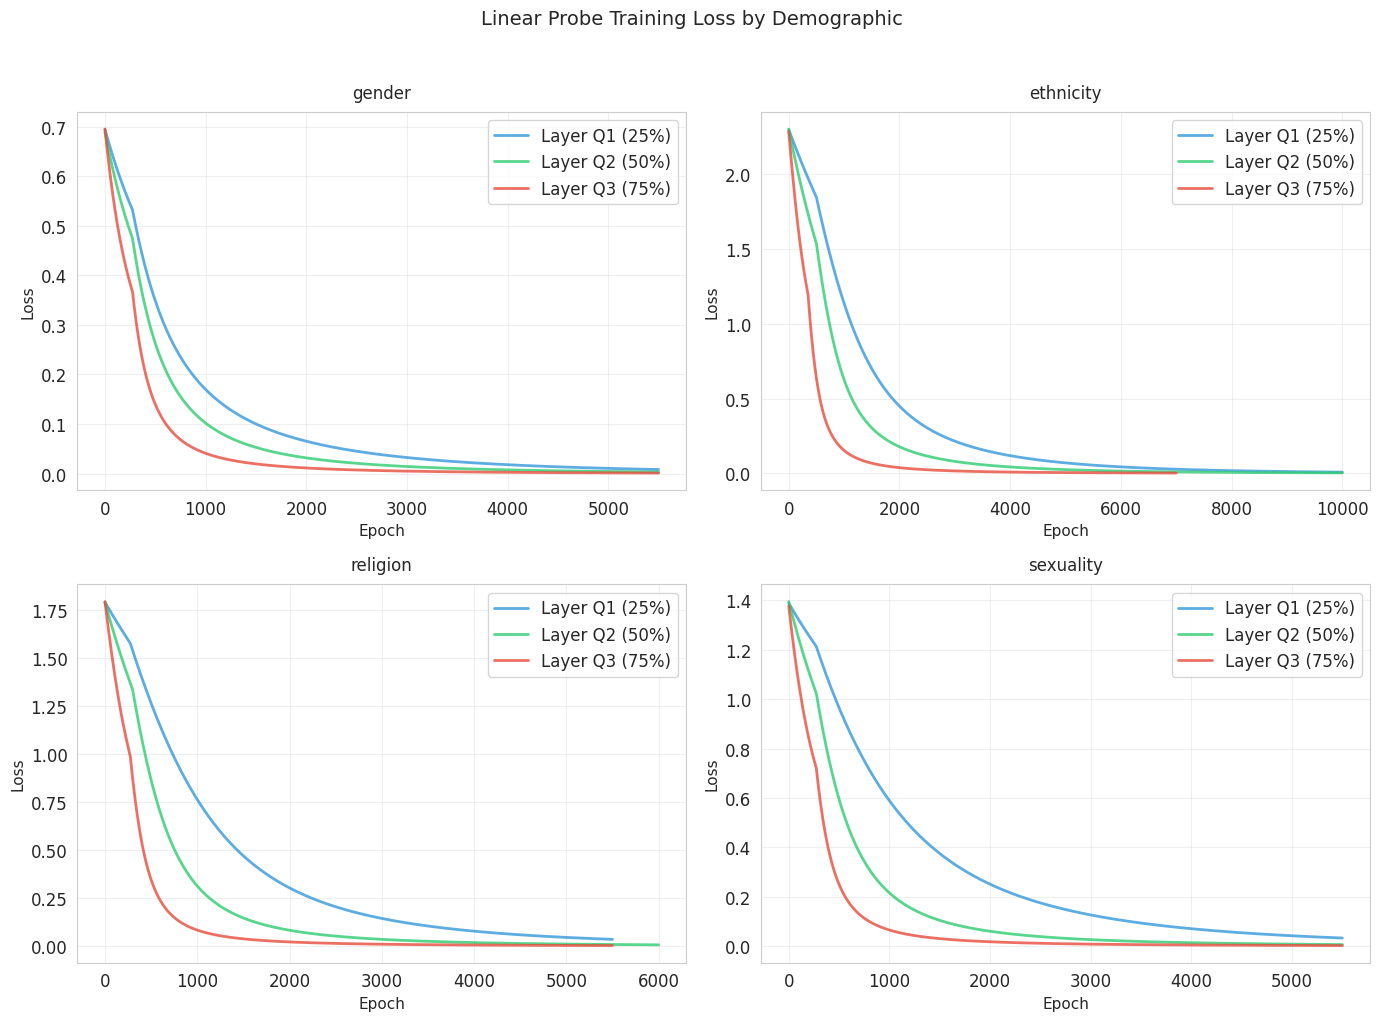

In [14]:
# Linear Probe Training Loss by Demographic
probe_losses = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                probe = available_results[demo][lq]['probe']
                if 'losses' in probe and len(probe['losses']) > 0:
                    probe_losses.append({
                        'Demographic': demo,
                        'Demographic_EN': DEMOGRAPHIC_EN[demo],
                        'Layer_Quantile': lq,
                        'Losses': probe['losses'],
                        'Accuracies': probe.get('accuracies', [])
                    })

if probe_losses:
    # Select subset of demographics for clarity
    demo_subset = DEMOGRAPHICS[:4] if len(DEMOGRAPHICS) > 4 else DEMOGRAPHICS
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = {'q1': '#3498db', 'q2': '#2ecc71', 'q3': '#e74c3c'}
    
    for idx, demo in enumerate(demo_subset):
        ax = axes[idx]
        demo_en = DEMOGRAPHIC_EN[demo]
        
        for lq in LAYER_QUANTILES:
            matching = [p for p in probe_losses if p['Demographic'] == demo and p['Layer_Quantile'] == lq]
            if matching:
                losses = matching[0]['Losses']
                # Smooth
                window = max(1, len(losses) // 20)
                smoothed = pd.Series(losses).rolling(window=window, min_periods=1).mean()
                ax.plot(smoothed, label=LAYER_LABELS[lq], color=colors[lq], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Loss', fontsize=11)
        ax.set_title(f'{demo_en}', fontsize=12, pad=10)  # Use English label only
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
    
    plt.suptitle('Linear Probe Training Loss by Demographic', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_training_loss_by_demo_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No probe training loss data found.")

---
## Summary Statistics Table

In [15]:
# Create comprehensive summary table with English labels
summary_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        row = {
            'Demographic': DEMOGRAPHIC_EN[demo],  # Use English label
            'Layer': lq,
            'Probe_Accuracy': None,
            'IG2_Max': None,
            'IG2_Max_Neuron': None,
            'IG2_Top10_Mean': None,
        }
        
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                row['Probe_Accuracy'] = available_results[demo][lq]['probe']['best_accuracy']
            
            if 'ig2' in available_results[demo][lq]:
                ig2_row = df_ig2[(df_ig2['Demographic'] == demo) & (df_ig2['Layer_Quantile'] == lq)]
                if len(ig2_row) > 0:
                    row['IG2_Max'] = ig2_row['Max_Score'].values[0]
                    row['IG2_Max_Neuron'] = int(ig2_row['Max_Neuron_Idx'].values[0])
                    row['IG2_Top10_Mean'] = ig2_row['Top10_Mean'].values[0]
        
        summary_data.append(row)

df_summary = pd.DataFrame(summary_data)

print("\n" + "=" * 100)
print("COMPREHENSIVE SUMMARY TABLE")
print("=" * 100)
print(df_summary.to_string(index=False))

# Save to CSV
df_summary.to_csv(ASSETS_DIR / f"layer_demographic_summary_{STAGE}.csv", index=False)
print(f"\nSaved summary to: {ASSETS_DIR / f'layer_demographic_summary_{STAGE}.csv'}")


COMPREHENSIVE SUMMARY TABLE
         Demographic Layer  Probe_Accuracy  IG2_Max  IG2_Max_Neuron  IG2_Top10_Mean
              gender    q1        1.000000 0.387639           53911        0.301691
              gender    q2        1.000000 0.437685           67974        0.301581
              gender    q3        1.000000 0.448949           71521        0.321749
           ethnicity    q1        1.000000 0.687645           12574        0.399523
           ethnicity    q2        1.000000 0.497052           83760        0.304694
           ethnicity    q3        1.000000 0.493965           70570        0.320583
            religion    q1        1.000000 0.622936           38258        0.344951
            religion    q2        1.000000 0.543364           67974        0.314908
            religion    q3        1.000000 0.526453           70570        0.339286
           sexuality    q1        1.000000 0.573826           38258        0.292698
           sexuality    q2        1.000000 0.48